# Tratamento

In [ ]:
!pip3 install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
def passengerid_new_features(df):
    
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member"] =df["PassengerId"].apply(lambda x: x.split("_")[1])
    
    x = df.groupby("Group")["Member"].count().sort_values()
    
    y = set(x[x>1].index)
    
    df["Travelling_Solo"] = df["Group"].apply(lambda x: x not in y)
    
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"]==i[0],"Group_Size"]=i[1]

In [ ]:
passengerid_new_features(train_df)
passengerid_new_features(test_df)

In [ ]:
train_df.drop(columns=["Group","Member"],inplace=True)
test_df.drop(columns=["Group","Member"],inplace=True)

In [ ]:
train_df["Cabin"].head().to_frame()

,Cabin
0,B/0/P
1,F/0/S
2,A/0/S
3,A/0/S
4,F/1/S


In [ ]:
def cabin_new_feature(df):
    df["Cabin"].fillna("np.nan/np.nan/np.nan",inplace=True)
    
    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"]  = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    
    cols = ["Cabin_Deck","Cabin_Number","Cabin_Side"]
    df[cols]=df[cols].replace("np.nan",np.nan)
    
    df["Cabin_Deck"].fillna(df["Cabin_Deck"].mode()[0],inplace=True)
    df["Cabin_Side"].fillna(df["Cabin_Side"].mode()[0],inplace=True)
    df["Cabin_Number"].fillna(df["Cabin_Number"].median(),inplace=True)

In [ ]:
cabin_new_feature(train_df)
cabin_new_feature(test_df)

In [ ]:
train_df["Cabin_Number"]=train_df["Cabin_Number"].astype(int)
test_df["Cabin_Number"]=test_df["Cabin_Number"].astype(int)

In [ ]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

In [ ]:
cabin_regions(train_df)
cabin_regions(test_df)

In [ ]:
train_df.drop(columns=["Cabin_Number"],inplace=True)
test_df.drop(columns=["Cabin_Number"],inplace=True)

In [ ]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_0-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("age_50+")
        else:
            age_group.append(np.nan)
        
    df["Age Group"] = age_group

In [ ]:
age_group(train_df)
age_group(test_df)

In [ ]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def new_exp_features(df):
    df["Total Expenditure"] = df[exp_cols].sum(axis=1)
    df["No Spending"] = (df["Total Expenditure"]==0)

In [ ]:
new_exp_features(train_df)
new_exp_features(test_df)

In [ ]:
def expenditure_category(df):
    expense_category = []
    
    for i in df["Total Expenditure"]:
        if i==0:
            expense_category.append("No Expense")
        elif (i>0 and i<=716):
            expense_category.append("Low Expense")
        elif (i>716 and i<=1441):
            expense_category.append("Medium Expense")
        elif (i>1441):
            expense_category.append("High Expense")
    
    df["Expenditure Category"] = expense_category

In [ ]:
expenditure_category(train_df)
expenditure_category(test_df)

In [ ]:
train_df.head()

In [ ]:
cat_cols = train_df.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = train_df.select_dtypes(include=["int","float"]).columns.tolist()

In [ ]:
print("Categorical Columns:",cat_cols)
print("\n","-"*120)
print("\nNumerical Columns:",num_cols)

In [ ]:
imputer1 = SimpleImputer(strategy="most_frequent")
imputer2 = SimpleImputer(strategy="median") 

In [ ]:
def fill_missingno(df):
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

In [ ]:
fill_missingno(train_df)
fill_missingno(test_df)

In [ ]:
pass_df = test_df[["PassengerId"]]

In [ ]:
cols = ["PassengerId","Cabin","Name"]
train_df.drop(columns =cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

In [ ]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total Expenditure']

for value in cols:
    train_df[value] = np.log(1+train_df[value])
    test_df[value]=np.log(1+test_df[value])

In [ ]:
cols = ["CryoSleep","VIP","Travelling_Solo","No Spending","Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4",
       "Cabin_Region5","Cabin_Region6"]

train_df[cols] = train_df[cols].astype(bool)
test_df[cols] = test_df[cols].astype(bool)

In [ ]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Travelling_Solo","Cabin_Deck","Cabin_Side","Cabin_Region1","Cabin_Region2",
                    "Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6","Age Group","No Spending",
                    "Expenditure Category"]

In [ ]:
enc = LabelEncoder()

In [ ]:
train_df[ordinal_cat_cols] = train_df[ordinal_cat_cols].apply(enc.fit_transform)
test_df[ordinal_cat_cols] = test_df[ordinal_cat_cols].apply(enc.fit_transform)

In [ ]:
train_df = pd.get_dummies(train_df,columns=nominal_cat_cols)
test_df = pd.get_dummies(test_df,columns=nominal_cat_cols)

In [ ]:
train_df["Transported"].replace({False:0,True:1},inplace=True)

In [ ]:
X = train_df.drop(columns=["Transported"])
y = train_df[["Transported"]]

In [ ]:
scaler = StandardScaler()

In [ ]:
X_scaled = scaler.fit_transform(X)
test_df_scaled = scaler.fit_transform(test_df)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_scaled,y,test_size=0.2,random_state=0)

In [ ]:
training_score = []
testing_score = []

In [ ]:
def model_prediction(model):
    model.fit(x_train1,y_train1)
    x_train_pred1 = model.predict(x_train1)
    x_test_pred1 = model.predict(x_test1)
    a = accuracy_score(y_train1,x_train_pred1)*100
    b = accuracy_score(y_test1,x_test_pred1)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test1,x_test_pred1))
    print(f"Recall Score of {model} model is:",recall_score(y_test1,x_test_pred1))
    print(f"F1 Score of {model} model is:",f1_score(y_test1,x_test_pred1))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test1,x_test_pred1)
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")

# Modelos com escalonamento de valores

## Linear Regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of LogisticRegression() model on Training Data is: 77.8688524590164
Accuracy_Score of LogisticRegression() model on Testing Data is: 77.17078780908568

------------------------------------------------------------------------
Precision Score of LogisticRegression() model is: 0.7578040904198062
Recall Score of LogisticRegression() model is: 0.8036529680365296
F1 Score of LogisticRegression() model is: 0.7800554016620498

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression() model is:


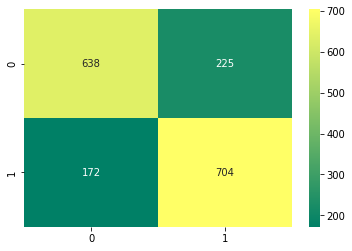

In [ ]:
model_prediction(LogisticRegression())

## kNN

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy_Score of KNeighborsClassifier() model on Training Data is: 83.14639056658038
Accuracy_Score of KNeighborsClassifier() model on Testing Data is: 75.50316273720529

------------------------------------------------------------------------
Precision Score of KNeighborsClassifier() model is: 0.7697841726618705
Recall Score of KNeighborsClassifier() model is: 0.7328767123287672
F1 Score of KNeighborsClassifier() model is: 0.7508771929824561

------------------------------------------------------------------------
Confusion Matrix of KNeighborsClassifier() model is:


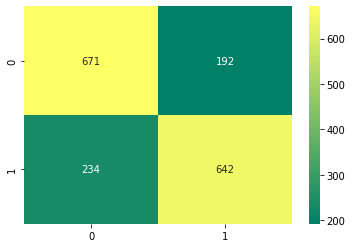

In [ ]:
model_prediction(KNeighborsClassifier())

## SVM

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of SVC() model on Training Data is: 81.8234109864826
Accuracy_Score of SVC() model on Testing Data is: 79.700977573318

------------------------------------------------------------------------
Precision Score of SVC() model is: 0.7995418098510882
Recall Score of SVC() model is: 0.7968036529680366
F1 Score of SVC() model is: 0.7981703830760436

------------------------------------------------------------------------
Confusion Matrix of SVC() model is:


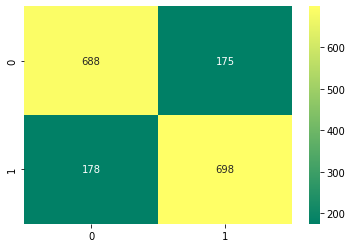

In [ ]:
model_prediction(SVC())

## Naive-Bayes

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of GaussianNB() model on Training Data is: 73.94305435720449
Accuracy_Score of GaussianNB() model on Testing Data is: 73.3755031627372

------------------------------------------------------------------------
Precision Score of GaussianNB() model is: 0.7779273216689099
Recall Score of GaussianNB() model is: 0.6598173515981736
F1 Score of GaussianNB() model is: 0.7140210006176654

------------------------------------------------------------------------
Confusion Matrix of GaussianNB() model is:


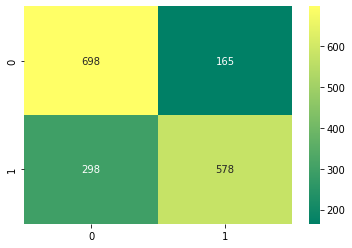

In [ ]:
model_prediction(GaussianNB())

# Modelos sem escalonamento de valores

In [ ]:
def model_prediction(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test,x_test_pred))
    print(f"Recall Score of {model} model is:",recall_score(y_test,x_test_pred))
    print(f"F1 Score of {model} model is:",f1_score(y_test,x_test_pred))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")

## Decision Tree

Accuracy_Score of DecisionTreeClassifier() model on Training Data is: 98.53321829163072
Accuracy_Score of DecisionTreeClassifier() model on Testing Data is: 74.35307648073606

------------------------------------------------------------------------
Precision Score of DecisionTreeClassifier() model is: 0.7415730337078652
Recall Score of DecisionTreeClassifier() model is: 0.7534246575342466
F1 Score of DecisionTreeClassifier() model is: 0.7474518686296717

------------------------------------------------------------------------
Confusion Matrix of DecisionTreeClassifier() model is:


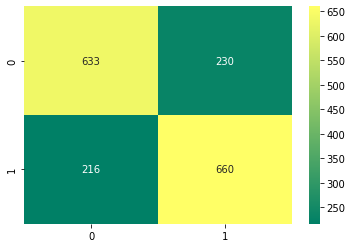

In [ ]:
model_prediction(DecisionTreeClassifier())

## Random Forest

<ipython-input-250-ade87c2a6f2c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


Accuracy_Score of RandomForestClassifier() model on Training Data is: 98.51883807880355
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 80.21851638872916

------------------------------------------------------------------------
Precision Score of RandomForestClassifier() model is: 0.8267813267813268
Recall Score of RandomForestClassifier() model is: 0.7682648401826484
F1 Score of RandomForestClassifier() model is: 0.7964497041420118

------------------------------------------------------------------------
Confusion Matrix of RandomForestClassifier() model is:


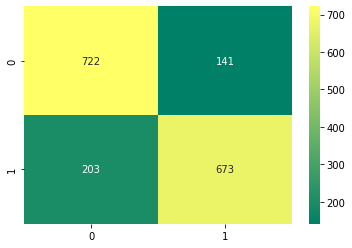

In [ ]:
model_prediction(RandomForestClassifier())

## Ada Boost Classifier

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of AdaBoostClassifier() model on Training Data is: 79.98274374460742
Accuracy_Score of AdaBoostClassifier() model on Testing Data is: 79.24094307073031

------------------------------------------------------------------------
Precision Score of AdaBoostClassifier() model is: 0.7657378740970072
Recall Score of AdaBoostClassifier() model is: 0.8470319634703196
F1 Score of AdaBoostClassifier() model is: 0.8043360433604336

------------------------------------------------------------------------
Confusion Matrix of AdaBoostClassifier() model is:


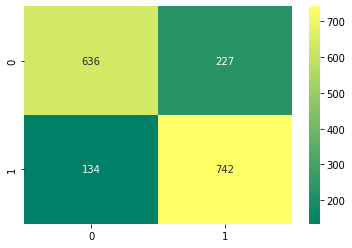

In [ ]:
model_prediction(AdaBoostClassifier())

## Gradient Boosting Classifier

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of GradientBoostingClassifier() model on Training Data is: 82.053494391717
Accuracy_Score of GradientBoostingClassifier() model on Testing Data is: 79.29844738355378

------------------------------------------------------------------------
Precision Score of GradientBoostingClassifier() model is: 0.7721518987341772
Recall Score of GradientBoostingClassifier() model is: 0.8356164383561644
F1 Score of GradientBoostingClassifier() model is: 0.8026315789473685

------------------------------------------------------------------------
Confusion Matrix of GradientBoostingClassifier() model is:


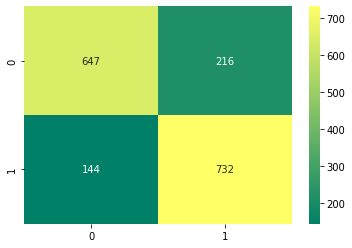

In [ ]:
model_prediction(GradientBoostingClassifier())

## LGMB Classifier

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of LGBMClassifier() model on Training Data is: 88.10756399194707
Accuracy_Score of LGBMClassifier() model on Testing Data is: 81.25359401955147

------------------------------------------------------------------------
Precision Score of LGBMClassifier() model is: 0.802863436123348
Recall Score of LGBMClassifier() model is: 0.8321917808219178
F1 Score of LGBMClassifier() model is: 0.8172645739910315

------------------------------------------------------------------------
Confusion Matrix of LGBMClassifier() model is:


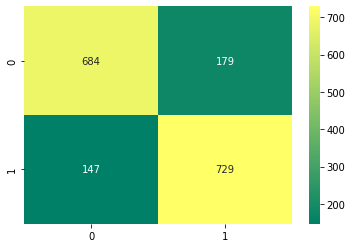

In [ ]:
model_prediction(LGBMClassifier())

## XGBClassifier 

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of XGBClassifier() model on Training Data is: 81.80903077365545
Accuracy_Score of XGBClassifier() model on Testing Data is: 79.18343875790684

------------------------------------------------------------------------
Precision Score of XGBClassifier() model is: 0.7734042553191489
Recall Score of XGBClassifier() model is: 0.8299086757990868
F1 Score of XGBClassifier() model is: 0.8006607929515418

------------------------------------------------------------------------
Confusion Matrix of XGBClassifier() model is:


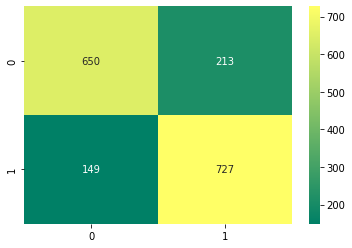

In [ ]:
model_prediction(XGBClassifier())

## CatBoost Classifier

Accuracy_Score of <catboost.core.CatBoostClassifier object at 0x7fd7b08aed00> model on Training Data is: 87.331032499281
Accuracy_Score of <catboost.core.CatBoostClassifier object at 0x7fd7b08aed00> model on Testing Data is: 81.36860264519838

------------------------------------------------------------------------
Precision Score of <catboost.core.CatBoostClassifier object at 0x7fd7b08aed00> model is: 0.8032967032967033
Recall Score of <catboost.core.CatBoostClassifier object at 0x7fd7b08aed00> model is: 0.8344748858447488
F1 Score of <catboost.core.CatBoostClassifier object at 0x7fd7b08aed00> model is: 0.8185890257558791

------------------------------------------------------------------------
Confusion Matrix of <catboost.core.CatBoostClassifier object at 0x7fd7b08aed00> model is:


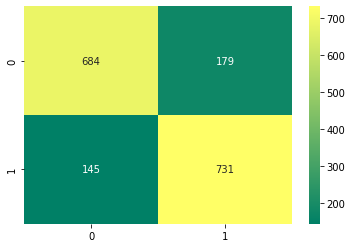

In [ ]:
model_prediction(CatBoostClassifier(verbose=False))

# Comparação de todos os modelos

In [ ]:
models = ["Logistic Regression","KNN","SVM","Naive Bayes","Decision Tree","Random Forest","Ada Boost",
          "Gradient Boost","LGBM","XGBoost","CatBoost"]

In [ ]:
df = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score})

In [ ]:
df.sort_values(by='Testing Score', ascending=False)

,Algorithms,Training Score,Testing Score
10,CatBoost,87.331032,81.368603
8,LGBM,88.107564,81.253594
5,Random Forest,98.518838,80.218516
2,SVM,81.823411,79.700978
7,Gradient Boost,82.053494,79.298447
6,Ada Boost,79.982744,79.240943
9,XGBoost,81.809031,79.183439
0,Logistic Regression,77.868852,77.170788
1,KNN,83.146391,75.503163
4,Decision Tree,98.533218,74.353076


# Hyper-Parameter Tunning LGBM 

In [ ]:
model1 = LGBMClassifier()

In [ ]:
parameters1 = {"n_estimators":[100,300,500,600,650],
              "learning_rate":[0.01,0.02,0.03],
              "random_state":[0,42,48,50],
               "num_leaves":[16,17,18]}

In [ ]:
grid_search1 = GridSearchCV(model1, parameters1, cv=5, n_jobs=-1)
grid_search1.fit(x_train,y_train.values.ravel())

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'n_estimators': [100, 300, 500, 600, 650],
                         'num_leaves': [16, 17, 18],
                         'random_state': [0, 42, 48, 50]})

In [ ]:
best_parameters1 = grid_search1.best_params_
best_parameters1

{'learning_rate': 0.02,
 'n_estimators': 300,
 'num_leaves': 18,
 'random_state': 0}

In [ ]:
model1 = LGBMClassifier(**best_parameters1)

In [ ]:
model1.fit(x_train,y_train)

In [ ]:
x_test_pred1 = model1.predict(x_test)

In [ ]:
accuracy_score(y_test,x_test_pred1)

0.8027602070155262

# Hyper-Parameter Tunning CatBoost 

In [ ]:
model2 = CatBoostClassifier(verbose=False)

In [ ]:
parameters2 = {"learning_rate":[0.1,0.3,0.5,0.6,0.7],
              "random_state":[0,42,48,50],
               "depth":[8,9,10],
               "iterations":[35,40,50]}

In [ ]:
grid_search2 = GridSearchCV(model2, parameters2, cv=5, n_jobs=-1)
grid_search2.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd79b0b3160>,
             n_jobs=-1,
             param_grid={'depth': [8, 9, 10], 'iterations': [35, 40, 50],
                         'learning_rate': [0.1, 0.3, 0.5, 0.6, 0.7],
                         'random_state': [0, 42, 48, 50]})

In [ ]:
best_parameters2 = grid_search2.best_params_
best_parameters2

{'depth': 8, 'iterations': 50, 'learning_rate': 0.1, 'random_state': 42}

In [ ]:
model2 = CatBoostClassifier(**best_parameters2,verbose=False)

In [ ]:
model2.fit(x_train,y_train)

In [ ]:
x_test_pred2 = model2.predict(x_test)

In [ ]:
accuracy_score(y_test,x_test_pred2)

0.8010350776308223

# Hyper-Parameter Tunning XGBoost 

In [ ]:
model3 = XGBClassifier()

In [ ]:
parameters3 = {"n_estimators":[50,100,150],
             "random_state":[0,42,50],
             "learning_rate":[0.1,0.3,0.5,1.0]}

In [ ]:
grid_search3 = GridSearchCV(model3, parameters3 , cv=5, n_jobs=-1)
grid_search3.fit(x_train,y_train)

In [ ]:
best_parameters3 = grid_search3.best_params_
best_parameters3

{'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 0}

In [ ]:
model3 = XGBClassifier(**best_parameters3)

In [ ]:
model3.fit(x_train,y_train)

XGBClassifier(learning_rate=0.5, n_estimators=50)

In [ ]:
x_test_pred3 = model3.predict(x_test)

In [ ]:
accuracy_score(y_test,x_test_pred3)

0.8004600345025877

# Hyper Parameter Tunning RandomForest 

In [ ]:
model4 = RandomForestClassifier()

In [ ]:
parameters4 = {'n_estimators': [100,300,500,550],
               'min_samples_split':[7,8,9],
               'max_depth': [10,11,12], 
               'min_samples_leaf':[4,5,6]}

In [ ]:
grid_search4 = GridSearchCV(model4, parameters4, cv=5, n_jobs=-1)
grid_search4.fit(x_train,y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [7, 8, 9],
                         'n_estimators': [100, 300, 500, 550]})

In [ ]:
best_parameters4 = grid_search4.best_params_
best_parameters4

{'max_depth': 12,
 'min_samples_leaf': 5,
 'min_samples_split': 9,
 'n_estimators': 500}

In [ ]:
model4 = RandomForestClassifier(**best_parameters4)

In [ ]:
model4.fit(x_train,y_train)

In [ ]:
x_test_pred4 = model4.predict(x_test)

In [ ]:
accuracy_score(y_test,x_test_pred4)

0.8010350776308223

# Stacking Classifier 

In [ ]:
stacking_model = StackingClassifier(estimators=[('LGBM', model1), 
                                                ('CAT Boost', model2),
                                                ("XGBoost", model3),
                                                ('RF', model4)]
                                    )

In [ ]:
stacking_model.fit(x_train, y_train)

In [ ]:
x_train_pred5 = stacking_model.predict(x_train)

In [ ]:
x_test_pred5 = stacking_model.predict(x_test)

In [ ]:
accuracy_score(y_train,x_train_pred5)

0.8372159907966638

In [ ]:
accuracy_score(y_test,x_test_pred5)

0.8039102932719954

# Predição

In [ ]:
pred = stacking_model.predict(test_df)
pred

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
pass_df["Transported"] = pred

In [ ]:
pass_df["Transported"].replace({1:True,0:False},inplace=True)

In [ ]:
pass_df.to_csv("spaceship_titanic_predicaoV1.csv",index=False)